In [2]:
#from structure_and_load import load
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.ndimage as spn 
from open_data  import matlab_file
from structure_data import  structure
from compute.classif import classify

import re
import neo 
from neo.core import Event
from quantities import s 
from quantities import millisecond as ms

import os
import sys

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [3]:
lab_desktop = True

if lab_desktop : 
    session = 't150204001'
    data_path = f'/home/INT/mifsud.l/Bureau/data/Tommy/{session}/modified_data/' #f'~/Bureau/data/Tommy/{session}/modified_data'
    info_path = '/home/INT/mifsud.l/Bureau/Lists&Documentation/TomyCerebusSpikes_Updated_June2023.xlsx'

else : 
    session = 't150204001'
    data_path = f'/home/laurie/Bureau/pattern_classification/data/Tommy_new/{session}/modified_data/'
    info_path = '/home/laurie/Bureau/pattern_classification/data/Tommy_new/session_info.xlsx'

print(f'session : {session}')

session : t150204001


In [4]:
# import data from matlab file
data, load_info = matlab_file.open(data_path)
# clean data 
df = matlab_file.clean(info_path)
# get sessions and units info 
info_units,  info_session = structure.info(load_info, df, session)
# manage elitrials format
info_session['elitrials'] = info_session['elitrials'].apply(structure.elitrials)
print(info_session.shape)

# get unit's index without eli trials 
completeUnit = structure.CompleteTasktime(info_session, load_info, session)


43 files loaded


(45, 8)
     start  stop elitrials
159      1    11      None 

unit_info : [1 3 1]
t150204001_probe1_contact3_unit1.mat

unit's loading index = 2


In [5]:
# extract data from the matlab file
spike_times = matlab_file.extract_spike_times(load_info, data)
task_data = matlab_file.extract_task_data(load_info, data, target_keys=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'], event_keys_OFF=['Sel_OFF', 'SC1_OFF', 'SC2_OFF', 'SC3_OFF'])

target_info = matlab_file.extract_target_info(load_info, data, target_keys=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'])
# get trials indices per condition
target_1 = np.where(target_info[completeUnit][1]['Trial_type'] == 1)[0]
target_2 = np.where(target_info[completeUnit][1]['Trial_type'] == 2)[0]
target_3 = np.where(target_info[completeUnit][1]['Trial_type'] == 3)[0]

event_labels = matlab_file.get_event_labels(task_data)
event_times = matlab_file.get_event_times(task_data, event_labels)
# reshape times by trials / periods for each neuron + Neo format
trials_ts, df_task_ts_by_neuron, events = structure.events_by_trial(event_times, event_labels)

unit_ = 32
trial_ = 12
print(f'times as list : {trials_ts[unit_][1][trial_]}')
print(f'times as neo events : {events[unit_][1][trial_].times}')
print(f'spike train sample : {spike_times[0][1]}\nevents : {event_labels}\ntargets : {target_info[0][1].keys()}')



times as list : [3047992 3049069 3050391 3051713 3053021 3054320 3054799]
times as neo events : [3047992. 3049069. 3050391. 3051713. 3053021. 3054320. 3054799.] ms
spike train sample : [    237    2137    3267 ... 3657198 3657250 3658579]
events : ['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time']
targets : dict_keys(['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'])


# Data formating

In [6]:
# get dataframe with each events times per trials for a complete session
tot_trials_in_task = trials_ts[completeUnit][1].shape[0]
df_task_ts = pd.DataFrame(trials_ts[completeUnit][1], columns=event_labels, index=np.arange(0, tot_trials_in_task))
df_task_ts.tail()

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
171,3427744,3428813,3430132,3431440,3432749,3434034,3434577
172,3488819,3489885,3491206,3492515,3493823,3495121,3495791
173,3498993,3500111,3501419,3502727,3504049,3505334,3506030
174,3518800,3519868,3521190,3522498,3523823,3525133,3525652
175,3534627,3535700,3537009,3538317,3539639,3540937,3541739


# units labels

In [7]:
def unit_label(info_units): 
    info_units_df = pd.DataFrame(info_units)
    count_unitProbe = list(info_units_df['probe'].value_counts(sort=False))

    n_units = len(spike_times)
    n_event = event_labels[:-1]

    unit_label = []
    unit_labelProbe1 = []
    unit_labelProbe2 = []

    for i in range(n_units):
        label = str(\
            'P' + str(info_units[i]['probe']) \
            + '-' + str(info_units[i]['contact']) \
            + '-' + str(info_units[i]['unit'])) 
        unit_label.append(label)

        if info_units[i]['probe'] == 1 :
            unit_labelProbe1.append(label)
        else : 
            unit_labelProbe2.append(label)

    return unit_label, unit_labelProbe1, unit_labelProbe2, count_unitProbe

unit_label, unit_labelProbe1, unit_labelProbe2, count_unitProbe = unit_label(info_units)
print(len(unit_labelProbe1) == count_unitProbe[0])
print(len(unit_labelProbe2) == count_unitProbe[1])
unit_labelTwoprobes = unit_label

True
True


#  Trials ref 

In [8]:
n_neurons = len(spike_times)
n_trials = df_task_ts.shape[0]
n_events = df_task_ts.shape[1] - 1 

In [9]:
for unit in range(n_neurons) :
    list_idx_trial = []
    times_unit = df_task_ts_by_neuron[unit][1]
    n_trials_unit = times_unit.shape[0]

    for trial in range(n_trials_unit):

        for i, event in enumerate(event_labels[:-1]):
            #print(f'trial :{trial}')            
            t_start = times_unit.loc[trial][f'{event}']
            t_stop = times_unit.loc[trial][f'{event_labels[i+1]}']
            idx_trial = df_task_ts[df_task_ts[f'{event}'] == t_start].index[0]

        list_idx_trial.append(idx_trial)
    df_task_ts_by_neuron[unit][1].insert(0, 'idx_ref_trial', list_idx_trial)


# Spike times formating (alignement, nan for invalid trials)

In [10]:
# get spike by trial for each neuron + Neo format (SpikeTrain)
from neo.core import SpikeTrain

def spike_ts_trial(n_neurons, trials_ts, spike_times):  
    '''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

    spk_trials = []
    spike_train = []
    

    for unit_idx in range(n_neurons):
        spk_trials.append([])
        spike_train.append([])

        n_trials = trials_ts[unit_idx][1].shape[0]

        for trial in range(n_trials):
            # define the start and end time of each trial
            t_start = trials_ts[unit_idx][1][trial,0]
            t_stop = trials_ts[unit_idx][1][trial,-1]
            
            # get spikes between start and end of trial 
            spk_tmp = spike_times[unit_idx][1] 
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
            
            # for trials without spikes 
            if spk_tmp[sel_spk].shape[0] == 0:
                spk_trials[unit_idx].append([])
                spike_train[unit_idx].append([])

            else :
                spk_ts_trial = SpikeTrain(spk_tmp[sel_spk]*ms, t_start=t_start, t_stop=t_stop, dtype='int32')
                # fill the matrice with spike times aligned to 0
                spike_train[unit_idx].append(spk_ts_trial)

    return spk_trials, spike_train
    

spk_trials, spike_train_trial = spike_ts_trial(n_neurons, trials_ts, spike_times)

In [11]:
'''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

def align_trials(df_task_ts, df_task_ts_by_neuron, spike_times):
    n_units = len(spike_times)

    for unit_idx in range(n_units):
        data = df_task_ts_by_neuron[unit_idx][1]
        list_trials_unit = list(data['idx_ref_trial'])

        nan_trials = [item for item in list_trials_task if item not in list_trials_unit]
        valid_trials = [item for item in list_trials_task if item in list_trials_unit]

        for idx_trial_valid, trial_valid in enumerate(valid_trials):
            # define the start and end time of each trial
            t_start = data.loc[idx_trial_valid][1]
            t_stop = data.loc[idx_trial_valid][-1]

            # get spikes between start and end of trial and align to zero
            spk_tmp = spike_times[unit_idx][1]
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
            spikes_times_aligned_ = []
                    
            for spk_idx, spk in enumerate(spk_tmp[sel_spk]):
                spk_aligned = spk - t_start
                spikes_times_aligned_.append(spk_aligned)
                        
            spikes_times_aligned[unit_idx][trial_valid]= {
                        'unit_label': unit_label[unit_idx], 
                        'trial_unit' : trial_valid, 
                        't_start_ref' : t_start,
                        't_start_aligned' : t_start - t_start,
                        't_stop_aligned': t_stop - t_start,
                        'spike_time' : np.array(spikes_times_aligned_, dtype=np.int32), 
                        'spike_train' : spike_train_trial[unit_idx][idx_trial_valid]
                        }

        for idx_trial_nan in (nan_trials):
            t_start_nan = df_task_ts.loc[idx_trial_nan][0]
            t_stop_nan = df_task_ts.loc[idx_trial_nan][-1]


            spikes_times_aligned[unit_idx][idx_trial_nan] = {
                        'unit_label': unit_label[unit_idx], 
                        'trial_unit' : idx_trial_nan, 
                        't_start_ref' : t_start_nan, 
                        't_start_aligned' : t_start_nan - t_start_nan,
                        't_stop_aligned': t_stop_nan - t_start_nan,
                        'spike_time' : np.zeros(1, dtype=np.int64),
                        'spike_train' :  np.zeros(1, dtype=np.int64)
                        }

    return spikes_times_aligned
    
list_trials_task = list(df_task_ts.index)
spikes_times_aligned = np.zeros((n_neurons, n_trials), dtype=object)
spikes_times_aligned = align_trials(df_task_ts, df_task_ts_by_neuron, spike_times)


/tmp/ipykernel_14927/3040918305.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_start = data.loc[idx_trial_valid][1]
/tmp/ipykernel_14927/3040918305.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_stop = data.loc[idx_trial_valid][-1]
/tmp/ipykernel_14927/3040918305.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_start_nan = df_task_ts.loc[idx_trial_nan][0]
/tmp/ipykernel_14927/3040918305.py:39: FutureWarning: Se

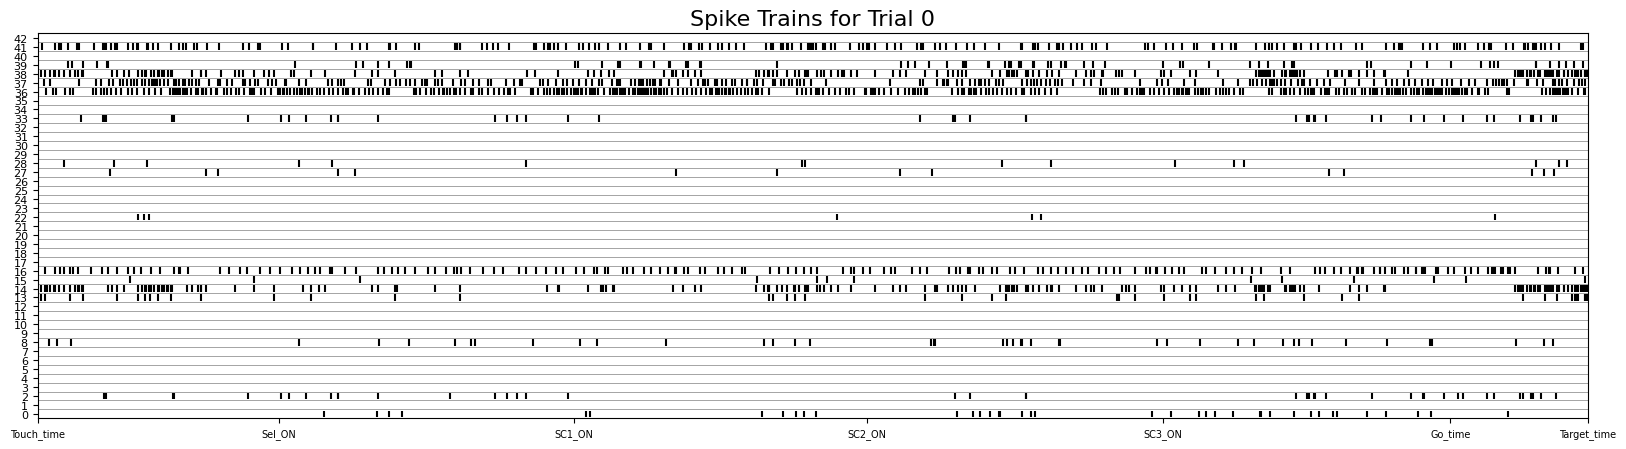

In [12]:
t = 0
event_vector = df_task_ts.loc[t]

plt.figure(figsize=(20, 5))  # Ajustez la taille de la figure selon vos besoins

# Parcourir tous les neurones et tracer leur spike train
for n in range(n_neurons): 
    spiketrain = spikes_times_aligned[n][t]['spike_train']
    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        plt.eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=n, color='black')
for i in range(n_neurons - 1):
    plt.hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
plt.xticks(event_vector.values, event_labels, fontsize=7)
plt.yticks(range(n_neurons), [f"{i}" for i in range(n_neurons)], fontsize=8)
plt.title(f"Spike Trains for Trial {t}", fontsize=16)

# Ajuster les limites des axes
plt.xlim(event_vector.min(), event_vector.max())
plt.ylim(-0.5, 42.5)

plt.show()


# Firing rate (fr) convolution

In [14]:
max_length = 8000
def binarize_spike_times(spikes_times_aligned):
    spikes_binarized = np.zeros((n_trials, max_length, n_neurons), dtype=float)
    for n in range(n_neurons):
        for t in range(n_trials):
            spiketrain = spikes_times_aligned[n][t]['spike_train']
            t_start = spikes_times_aligned[n][t]['t_start_ref'] 

            if len(spiketrain) > 0 and spiketrain[0] != 0:
                spk = spiketrain.magnitude - t_start
                spikes_binarized[t, spk, n] = 1 
            else : 
                spikes_binarized[t,:,n] = 0 
    
    return spikes_binarized
        
spikes_binarized = binarize_spike_times(spikes_times_aligned)

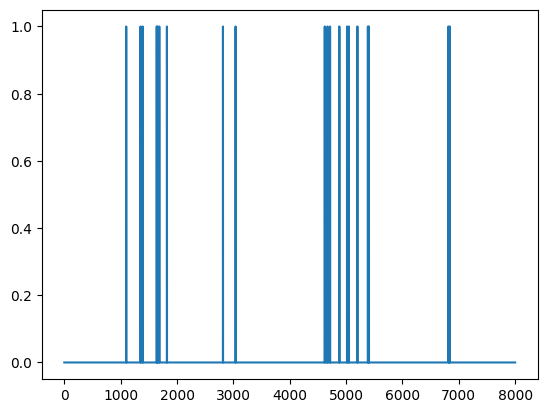

In [15]:
plt.plot(spikes_binarized[121,:,10])

In [16]:
def convolve_spike_binarized(spikes_binarized, sigma):
    n_sigma = len(sigma)
    delta_time = 1
    sigma_dt = sigma * delta_time 
    spike_convolved = np.zeros((n_trials, max_length, n_neurons, n_sigma))

    for idx, s in enumerate(sigma):
        scaling = sigma_dt[idx] * np.sqrt(2*np.pi)
        for t in range(n_trials) : 
            for n in range(n_neurons):
                smoothed_spk = spn.gaussian_filter1d(spikes_binarized[t,:,n], sigma_dt[idx]) * scaling
                spike_convolved[t,:,n,idx] = smoothed_spk
    
    return spike_convolved

In [17]:
sigma = [10, 50, 100]
spike_convolved = convolve_spike_binarized(spikes_binarized, sigma)

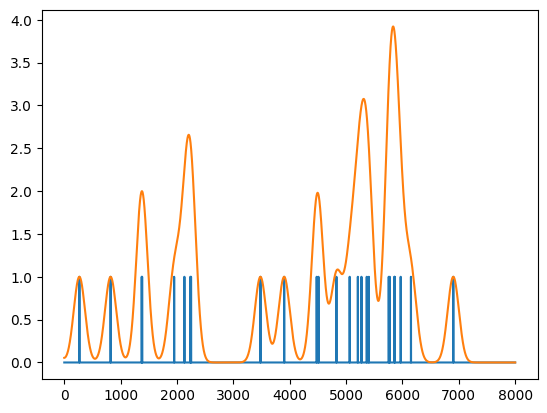

In [18]:
plt.plot(spikes_binarized[121,:,0])
plt.plot(spike_convolved[121,:,0,2])

# Classif

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

In [20]:
# Build pipeline
n_splits = 5
# Cross-validation scheme
cvs0 = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2)
scaler = StandardScaler()
estimator = LogisticRegression(C = 0.5, random_state=0, max_iter = 500)
clf = make_pipeline(scaler, estimator)

In [21]:
target = pd.DataFrame(target_info[completeUnit][1]['Trial_type'], columns=['trial_type'])
n_times = list(np.arange(0,spike_convolved.shape[1], 10))
n_bins = len(n_times)

In [22]:
# Initialiser une liste vide pour stocker les moyennes de bin
FR_mean_bin = []

# Calculer les moyennes pour chaque bin et chaque paire
for start, end in zip(n_times[:-1], n_times[1:]):
    # Extraire les données pour le bin actuel
    bin_data = spike_convolved[:, start:end, :,2]
    # Calculer la moyenne sur l'axe des temps
    bin_mean = np.nanmean(bin_data, axis=1)
    # Convertir les moyennes en DataFrame et les ajouter à la liste
    bin_mean_df = pd.DataFrame(bin_mean)
    FR_mean_bin.append(bin_mean_df)

In [23]:
class Model_info:

    def __init__(self, n_splits, n_events, data, target, cvs, clf):
        self.n_splits = n_splits
        self.n_periods = n_events
        self.data = data
        self.target = target
        self.cvs = cvs
        self.clf = clf

In [24]:
list_FR_model = []

for idx, t in enumerate(n_times[:-1]):
    model_FR = Model_info(n_splits,\
             n_bins, FR_mean_bin[idx], target, cvs0, clf)
    list_FR_model.append(model_FR)

In [25]:
list_FR_model[0].data

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.0,0.000000,0.043916,0.0,0.0,0.0,0.000000,0.000000,3.737298,0.0,...,0.380223,0.0,0.000000,9.307668,4.065098,12.896746,1.740986,0.000000,9.507328,0.0
1,0.0,0.000000,2.936841,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,2.940925,0.0,0.000000,19.819128,1.870800,10.444125,0.128883,0.000000,0.981229,0.0
2,0.0,0.000000,1.076812,0.0,0.0,0.0,0.000000,0.000000,7.372035,0.0,...,1.571695,0.0,0.000000,12.120454,0.000000,14.989956,2.974875,0.000000,5.723277,0.0
3,0.0,0.000000,3.089705,0.0,0.0,0.0,0.000000,0.000000,0.938359,0.0,...,0.197352,0.0,0.000000,14.234468,13.308039,8.387294,2.210295,0.000000,8.402882,0.0
4,0.0,0.000000,10.869110,0.0,0.0,0.0,0.000000,0.000000,3.439407,0.0,...,0.786220,0.0,0.000000,3.427375,4.060172,5.111567,1.993458,0.000000,8.881397,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,0.0,3.643167,1.703126,0.0,0.0,0.0,0.029447,0.907420,0.000000,0.0,...,0.000000,0.0,0.843500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
172,0.0,0.810050,1.993796,0.0,0.0,0.0,0.000000,0.945280,0.000000,0.0,...,0.000000,0.0,1.535154,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
173,0.0,0.061122,0.000000,0.0,0.0,0.0,2.908205,1.363262,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.146693,0.000000,0.0
174,0.0,6.143936,0.275619,0.0,0.0,0.0,0.303100,0.904553,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.601866,0.000000,0.0


In [26]:
list_FR_model[1].data

,0,1,2,3,4,5,6,7,8,9,...,33,34,35,36,37,38,39,40,41,42
0,0.0,0.000000,0.047433,0.0,0.0,0.0,0.000000,0.000000,3.729660,0.0,...,0.394208,0.0,0.000000,9.295369,4.054044,12.883591,1.770084,0.000000,9.499900,0.0
1,0.0,0.000000,2.948093,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,...,2.952643,0.0,0.000000,19.750577,1.922639,10.531046,0.134639,0.000000,1.004900,0.0
2,0.0,0.000000,1.097576,0.0,0.0,0.0,0.000000,0.000000,7.346913,0.0,...,1.588356,0.0,0.000000,12.105285,0.000143,14.969286,2.975266,0.000000,5.754311,0.0
3,0.0,0.000000,3.167685,0.0,0.0,0.0,0.000000,0.000000,0.961897,0.0,...,0.204484,0.0,0.000000,14.216170,13.221775,8.401376,2.221767,0.000000,8.398722,0.0
4,0.0,0.000000,10.803787,0.0,0.0,0.0,0.000000,0.000000,3.421628,0.0,...,0.795143,0.0,0.000000,3.448801,4.044632,5.103630,1.993493,0.000000,8.835209,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,0.0,3.636077,1.691569,0.0,0.0,0.0,0.031740,0.915687,0.000000,0.0,...,0.000000,0.0,0.849552,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
172,0.0,0.828065,1.974033,0.0,0.0,0.0,0.000000,0.949920,0.000000,0.0,...,0.000000,0.0,1.562301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
173,0.0,0.064766,0.000000,0.0,0.0,0.0,2.913853,1.364107,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.147920,0.000000,0.0
174,0.0,6.145674,0.283680,0.0,0.0,0.0,0.311456,0.911700,0.000000,0.0,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,1.592945,0.000000,0.0


In [30]:


#acc = np.zeros(list_model[0][0].n_splits)
#acc_shuf = np.zeros(list_model[0][0].n_splits)
acc_df = pd.DataFrame(\
    columns=['split', 'data_type', 'period', 'target_type', 'accuracy', 'y_true', 'y_pred'])

model_ = list_FR_model[0]
data_ = list_FR_model[0].data
target_ = list_FR_model[0].target


for i_split, (train_ind, test_ind) in enumerate(model_.cvs.split(data_,target_)):

    print('#################')
    print('SPLIT :', i_split)
    print('##################')
    
    for idx, t in enumerate(n_times[:-1]):
        model = list_FR_model[idx]
        data = model.data
        target = model.target
        
        # train classifier 
        model.clf.fit(data.loc[train_ind,:], target_.loc[train_ind].values.ravel())
    
        # test classifier 
        y_pred =  model.clf.predict(data.loc[test_ind,:])
        y_true = target_.loc[test_ind].values
        
        acc = accuracy_score(y_true, y_pred)
        
        
        # save test perfomance
        d = {
            'split' : [i_split],
            'data_type': ['test'],
            'time': [t],
            'target_type' : target.columns[0], 
            'accuracy': [acc],
            'y_true' : [y_true],
            'y_pred': [y_pred]
            }

        acc_df = pd.concat((acc_df, pd.DataFrame(data=d)), ignore_index=True)
    
        #  train classfier on shuffled data
        ind_train_shuf = np.random.permutation(train_ind)
        model.clf.fit(data.loc[train_ind,:],  target_.loc[ind_train_shuf].values.ravel())
    
        # test classfier on shuffled data
        y_pred_shuf =  model.clf.predict(data.loc[test_ind,:])
        acc_shuf = accuracy_score(y_true, y_pred_shuf)
        
        # save shuffled perfomance
        d_shuff = {
            'split' : [i_split],
            'data_type': ['shuff'],
            'time': [t],                
            'target_type' : target.columns[0],
            'accuracy': [acc_shuf],
            'y_true' : [y_true],
            'y_pred': [y_pred_shuf]
            }
    
        acc_df = pd.concat((acc_df, pd.DataFrame(data=d_shuff)), ignore_index=True)

#################
SPLIT : 0
##################


/tmp/ipykernel_14927/2628984652.py:43: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  acc_df = pd.concat((acc_df, pd.DataFrame(data=d)), ignore_index=True)


#################
SPLIT : 1
##################
#################
SPLIT : 2
##################
#################
SPLIT : 3
##################
#################
SPLIT : 4
##################


In [31]:
acc_df

,split,data_type,period,target_type,accuracy,y_true,y_pred,time
0,0,test,NaN,trial_type,0.361111,"[[1], [1], [3], [2], [1], [2], [3], [3], [1], ...","[3, 1, 2, 1, 1, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, ...",0.0
1,0,shuff,NaN,trial_type,0.388889,"[[1], [1], [3], [2], [1], [2], [3], [3], [1], ...","[1, 3, 2, 2, 1, 1, 3, 2, 1, 2, 1, 2, 1, 2, 2, ...",0.0
2,0,test,NaN,trial_type,0.361111,"[[1], [1], [3], [2], [1], [2], [3], [3], [1], ...","[3, 1, 2, 1, 1, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, ...",10.0
3,0,shuff,NaN,trial_type,0.361111,"[[1], [1], [3], [2], [1], [2], [3], [3], [1], ...","[1, 1, 3, 3, 1, 3, 1, 2, 1, 3, 1, 2, 1, 2, 3, ...",10.0
4,0,test,NaN,trial_type,0.361111,"[[1], [1], [3], [2], [1], [2], [3], [3], [1], ...","[3, 1, 2, 1, 1, 3, 3, 3, 2, 2, 3, 2, 2, 2, 2, ...",20.0
...,...,...,...,...,...,...,...,...
7985,4,shuff,NaN,trial_type,0.416667,"[[1], [1], [2], [2], [3], [2], [1], [2], [2], ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",7960.0
7986,4,test,NaN,trial_type,0.416667,"[[1], [1], [2], [2], [3], [2], [1], [2], [2], ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",7970.0
7987,4,shuff,NaN,trial_type,0.416667,"[[1], [1], [2], [2], [3], [2], [1], [2], [2], ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",7970.0
7988,4,test,NaN,trial_type,0.416667,"[[1], [1], [2], [2], [3], [2], [1], [2], [2], ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",7980.0


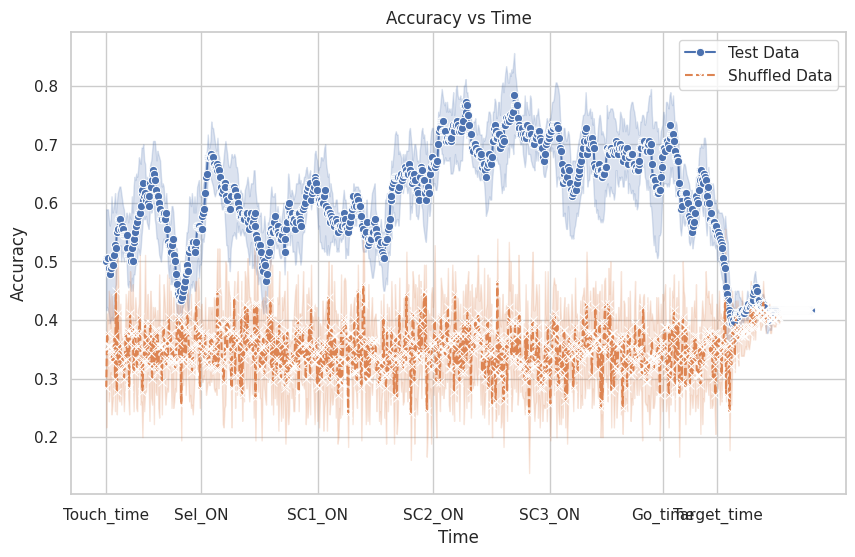

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Séparez les données par type
test_data = acc_df[acc_df['data_type'] == 'test']
shuff_data = acc_df[acc_df['data_type'] == 'shuff'] 

# Définir le style de seaborn
sns.set(style="whitegrid")

# Tracer les données
plt.figure(figsize=(10, 6))

# Tracer les données de test
sns.lineplot(data=test_data, x='time', y='accuracy', marker='o', linestyle='-', label='Test Data')

# Tracer les données de shuffled
sns.lineplot(data=shuff_data, x='time', y='accuracy', marker='x', linestyle='--', label='Shuffled Data')

# Définir les étiquettes d'axe et le titre
plt.xticks(events, event_labels)
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Time')

# Afficher la légende
plt.legend()

# Afficher le tracé
plt.show()

In [39]:
events = event_vector.values - event_vector[0]
event_labels 

/tmp/ipykernel_14927/2764716776.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  events = event_vector.values - event_vector[0]


['Touch_time',
 'Sel_ON',
 'SC1_ON',
 'SC2_ON',
 'SC3_ON',
 'Go_time',
 'Target_time']